In [12]:
%matplotlib inline

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed
from sklearn.preprocessing import MinMaxScaler

# modeling
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# progress bar
from tqdm import tqdm

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

Using TensorFlow backend.


In [21]:
def describe_training_data(train_df):
    num_training_series = train_df.series_id.nunique()
    num_training_days = num_training_series * 28
    num_training_hours = num_training_days * 24
    assert num_training_hours == train_df.shape[0]
    
    desc = f'There are {num_training_series} training ' \
           f'series totaling {num_training_days} days ' \
           f'({num_training_hours} hours) of consumption data.'
    
    print(desc)
    
def metric(y_true, y_pred, season=None):
    """
    It computes the score for a specific id and for a specific prediction 
    window. This function doesn't check if the two arguments have the same size
    and if both have the same timestamp. The predictions in y_pred are made 
    hourly.
    
    Args:
        y_true::DataFrame from pandas, Series from pandas 
            DataFrame with one column or more (it has to include consumption);
            consumption has the true values.
        
        y_pred::DataFrame from pandas, Series from pandas
            DataFrame with one column or more (it has to include consumption); 
            consumption has the predicted values.
            
        season::str
            There are three options: daily, weekly and hourly.
        
    Returns:
        score::float
            It gives the score for a specific id
        
    """
    
    window = {'daily': 24 / 7, 'weekly': 24 / 2, 'hourly': 24 / 24}
    
    if season == 'hourly':
        print(window.get('hourly'))
        ci = window.get('hourly') / y_true.consumption.values
        score = np.mean(np.abs(y_true.consumption.values - 
                                y_pred.consumption.values) * ci)
    
    if season == 'daily':
        print(window.get('daily'))
        
        div = y_pred.consumption.values.shape[0] / 24
        y_pred_div = np.split(y_pred.consumption.values, div)
        y_true_div = np.split(y_true.consumption.values, div)
        last_sum = []
        for i, array in enumerate(y_pred_div):
            ci = window.get('daily') / np.sum(y_true_div[i])
            print(ci)
            last_sum.append(np.abs(np.sum(y_true_div[i]) - 
                                   np.sum(array)) * ci)
        
        score = np.mean(last_sum)
    
    if season == 'weekly':
        print(window.get('weekly'))
        
        div = y_pred.consumption.values.shape[0] / 168
        y_pred_div = np.split(y_pred.consumption.values, div)
        y_true_div = np.split(y_true.consumption.values, div)
        last_sum = []
        for i, array in enumerate(y_pred_div):
            ci = window.get('daily') / np.sum(y_true_div[i])
            print(ci)
            last_sum.append(np.abs(np.sum(y_true_div[i]) - 
                                   np.sum(array)) * ci)
            print(last_sum)
        
        score = np.mean(last_sum)
        
    return score

def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['consumption'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(consumption.values.reshape(-1, 1))[-lag:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, lag), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [32]:
consumption_train_data = pd.read_csv('consumption_train.csv', 
                                index_col=0, parse_dates=['timestamp'])
cold_start_test = pd.read_csv('cold_start_test.csv', 
                              index_col=0, parse_dates=['timestamp'])
submission_format = pd.read_csv('submission_format.csv',
                                index_col='pred_id',
                                parse_dates=['timestamp'])
# copy submission format and fill in values
my_submission = submission_format.copy()

describe_training_data(consumption_train_data)
consumption_train_data.head(5)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


,series_id,timestamp,consumption,temperature
rowid,,,,
0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [45]:
# choose subset of series for training
frac_series_to_use = 0.1

rng = np.random.RandomState(seed=RANDOM_SEED)
series_ids = consumption_train_data.series_id.unique()
series_mask = rng.binomial(1,
                           frac_series_to_use,
                           size=series_ids.shape).astype(bool)
training_series = series_ids[series_mask]

# reduce training data to series subset
consumption_train = consumption_train_data[consumption_train_data.series_id.isin(training_series)]

# describe the reduced set
describe_training_data(consumption_train)

There are 81 training series totaling 2268 days (54432 hours) of consumption data.


# Visualize test and prediction windows

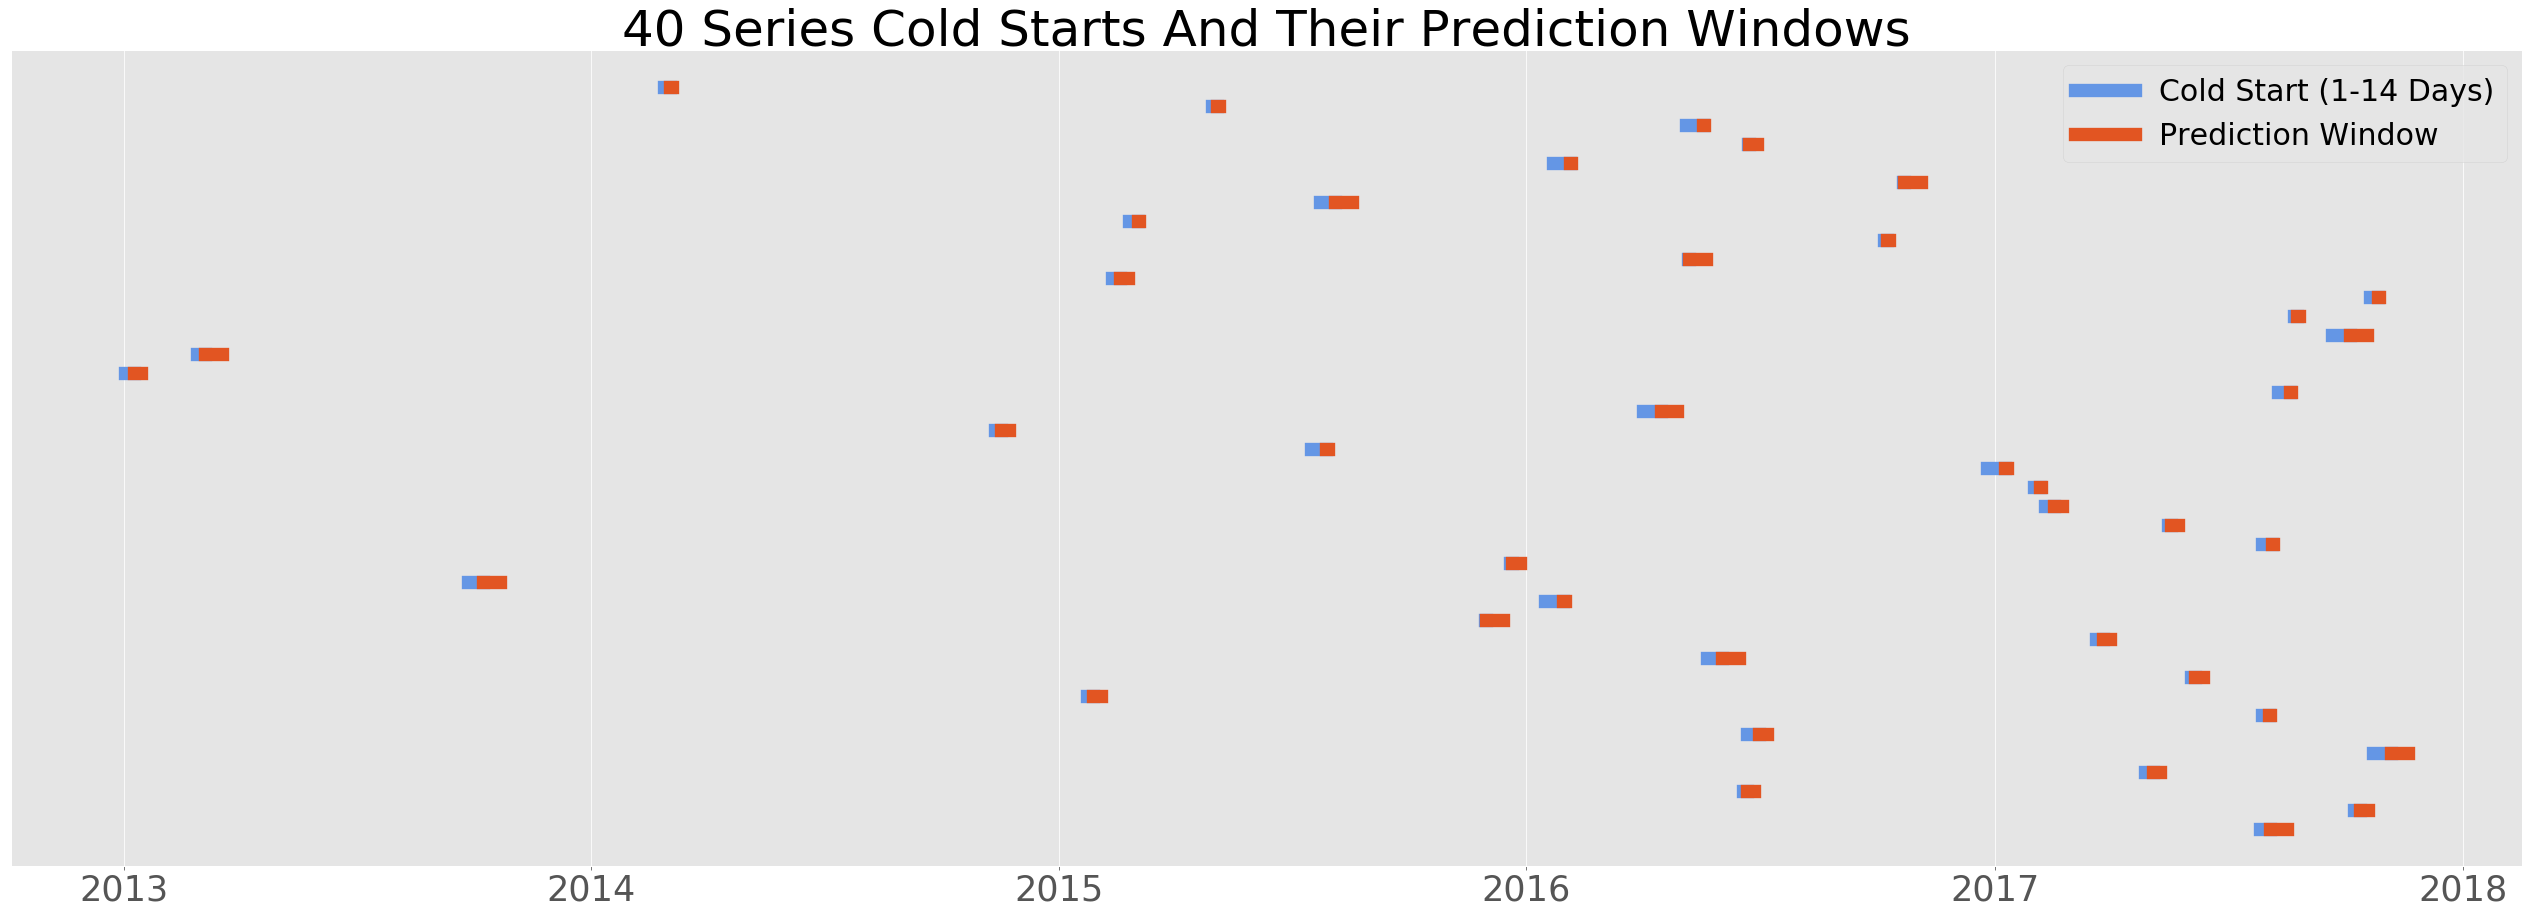

In [42]:
# visualize the cold start and prediction windows
num_to_plot = 40

fig, ax = plt.subplots(figsize=(45, 15))

cold_start_map = {'hourly': 1, 'daily': 7, 'weekly': 14}

rng = np.random.RandomState(seed=5425)
series_to_plot = rng.choice(cold_start_test.series_id.unique(), num_to_plot)

for i, series_id in enumerate(series_to_plot):
    # get relevant information about the test series from coldstart data
    series_data = cold_start_test[cold_start_test.series_id == series_id]
    start_cold = series_data.timestamp.min()
    start_preds = series_data.timestamp.max()
    
    # get prediction stop from submission format
    stop_preds = submission_format[submission_format.series_id == series_id].timestamp.max()
    
    # plot the cold start and prediction window relative sizes
    ax.plot([start_cold, start_preds], [i, i], c='#6496e5', linewidth=num_to_plot / 3)
    ax.plot([start_preds, stop_preds], [i, i], c='#e25522', linewidth=num_to_plot / 3)

# the y tick labels don't mean anything so turn them off
ax.set_yticks([])
plt.tick_params(labelsize=35)
plt.legend(['Cold Start (1-14 Days)', 
            'Prediction Window'], 
           fontsize=30)

plt.title(f'{num_to_plot} Series Cold Starts And Their Prediction Windows', fontsize=50);

# initiate a LSTM with tensorflow

In [43]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  24

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

# fit model

In [ ]:
%%time
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 10

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in consumption_train.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()


Learning Consumption Trends - Epoch:  30%|███       | 3/10 [04:32<10:36, 90.97s/it]

# make prediction

In [23]:
%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = cold_start_test[cold_start_test.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

Forecasting from Cold Start Data: 100%|██████████| 625/625 [04:41<00:00,  2.22it/s]


Wall time: 4min 41s


# submission

In [ ]:
save_path.mkdir(exist_ok=True, parents=True)

my_submission.to_csv("my_submmission.csv", index_label='pred_id')
!head ../data/submissions/my_submmission.csv